# LCP python code for Geodetic Imaging Dataa

The following script performs a least cost path analysis and is  a wrapper to skimage LCP algorithm. 

 This script claculates the LCP path using a Cost raster as input.
 There are 3 inputs required:
 1) Georeferenced cost raster in projected UTM CRS
 
 2) Two column tab delimited text file with UTM Easting and Northing that provides positino of the start point for the LCP
 
 3) Two column tab delimited text file with UTM Easting and Northing that provides positino of the end point for the LCP
 
 Output is a .txt file with UTM Easting, UTM Northing, Long, lat in four columns. 

 Required packages should already be installed using the environment.yml file. 
 Read the README.md file for instruction to install the packages and setup the enviornment.
 
 For licensing terms please see license file in top directory. 
 
 If using this script please cite Thomas et al. (2021)
 
 To run this code requires activating the pyLCP conda environment.

# Parameters

In [1]:
Data_4_LCP__PL_1_S2_2 = 2

Save_plot_fig = 1;# switch to Save the figures

# min and max values to set the color range 
# adjust these according to the values of the Cost function
min_color_plot_4_Cost = 0
max_color_plot_4_Cost = 60


# Import libraries

In [2]:
from skimage.graph import route_through_array
import numpy as np

# import os library
import os

# import gdal 
from osgeo import gdal, osr

import matplotlib.gridspec as gridspec


# Functions

In [3]:
def raster2array(Raster_path_filen):
    """Convert raster image to an array"""
    Im_Raster = gdal.Open(Raster_path_filen)# open raster file
    Im_band = Im_Raster.GetRasterBand(1)# get the first band of image
    Im_array = Im_band.ReadAsArray()# transform image to an array
    
    return Im_array  


In [4]:
def MapCoord2Pixel(Raster_path_filen,x,y):
    """Get pixel co-ordinates from map co-ordinates"""
    Im_Raster = gdal.Open(Raster_path_filen)
    Affine_transform = Im_Raster.GetGeoTransform()
    
    pix_dx = Affine_transform[1] 
    pix_dy = Affine_transform[5]
    
    UL_X = Affine_transform[0]
    UL_Y = Affine_transform[3] 

    x_coord = int((x - UL_X)/pix_dx)
    y_coord = int((y - UL_Y)/pix_dy)
    
    return x_coord,y_coord

In [5]:
def Est_LCP_Path(Cost_path_filen,Cost_Array,start_xy,stop_xy):   
    """Create LCP path and get indices in Image co-ord."""
    
    # For LCP need the start and end points in image co-ordinates. 
    # coordinates to array index for the start point
    start_X = start_xy[0]
    start_Y = start_xy[1]
    startIndexX,startIndexY = MapCoord2Pixel(Cost_path_filen,start_X,start_Y)
    # coordinates to array index for the end point
    stop_X = stop_xy[0]
    stop_Y = stop_xy[1]
    stopIndexX,stopIndexY = MapCoord2Pixel(Cost_path_filen,stop_X,stop_Y)

    # create LCP path
    LCP_indices, Weights = route_through_array(Cost_Array, (startIndexY,startIndexX), (stopIndexY,stopIndexX),geometric=True,fully_connected=True)
    LCP_indices = np.array(LCP_indices).T # transpose
    LCP_path_array = np.zeros_like(Cost_Array)
    LCP_path_array[LCP_indices[0], LCP_indices[1]] = 1
    
    return LCP_path_array,LCP_indices

In [6]:
def main(Cost_PathFilen,outputPathfn,startCoord,stopCoord):

    Cost_Array = raster2array(Cost_PathFilen) # creates array from cost surface raster

    LCP_path_array,LCP_indices = Est_LCP_Path(Cost_PathFilen,Cost_Array,startCoord,stopCoord) # creates path array
    
    return LCP_path_array,LCP_indices

In [7]:
def ReadinStartEndxy(Path_2_data,start_point_filename,end_point_filename):
    """Read in the two tab delimited text files that contain the start and end points for LCP"""
    
    import numpy # import numpy library 
    # import os library
    import os
  
    # change the current directory
    # to specified directory
    #os.chdir(Path_2_data)

    Start_xy = numpy.loadtxt(fname=start_point_filename, delimiter='\t')
    End_xy = numpy.loadtxt(fname=end_point_filename, delimiter='\t')

    return Start_xy,End_xy

In [8]:
def Pixel2Map(Cost_PathFilen, x, y):
        """
        :Method : convert pixel coordinate to map coordinate,
        :Note: The top Left coordinate of the image with GDAl correspond to (0,0)pix
        :param imagePath: path of the image  : string
        :param x: xPixel coordinate : int or float
        :param y: yPixel coordinate: int or float
        :return: xMap,yMap : tuple  (non integer coordinates)
        """
        
        raster = gdal.Open(Cost_PathFilen)
        geotransform = raster.GetGeoTransform()# get the 6  coefficients of the affine transformation

        xOrigin = geotransform[0]# offest term of x
        yOrigin = geotransform[3]# offset term in y
        pixelWidth = geotransform[1] 
        pixelHeight = geotransform[5]
        rtnX = geotransform[2]
        rtnY = geotransform[4]        
        
        ## Apply affine transformation
        mat = np.array([[pixelWidth, rtnX], [rtnY, pixelHeight]])
        trans = np.array([[xOrigin, yOrigin]])
        res = np.dot(mat, np.array([[x, y]]).T) + trans.T
        xMap = res[0].item()
        yMap = res[1].item()
        return (xMap, yMap)

In [9]:
def ConvCoordMap1ToMap2_Batch(X, Y, targetEPSG, Z=[], sourceEPSG=4326, display=False):
    """
    :Method: convert point coordinates from source to target system
    :param point x,y : map coordinate (e.g lon,lat)
    :param sourceEPSG: source coordinate system of the point; integer (default geographic coordinate )
    :param targetEPSG: target coordinate system of the point; integer
    :return: point in target coordinate system; list =[xCoord,yCoord,zCoord]

    Note: if the transformation from WGS to UTM, x= lat, y=lon ==> coord =(easting(xMap) ,northing(yMap))
    Note: if the transformation from UTM to WGS 84, x=easting, y=Notthing ==> lat, long
    """

    ## Set the source system
    import pyproj

    sourceEPSG_string = "epsg:" + str(sourceEPSG)
    targetEPSG_string = "epsg:" + str(targetEPSG)
    transformer = pyproj.Transformer.from_crs(sourceEPSG_string, targetEPSG_string)

    return transformer.transform(X, Y)


In [10]:
def View_LCP_Path(startCoord,stopCoord,Path_UTMx,Path_UTMy,Save_plot_fig):

    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots()

    # Plot just the LCP path
    plt.scatter(startCoord[0],startCoord[1],color='r')
    plt.scatter(stopCoord[0],stopCoord[1],color='g')
    # Plot LCP path
    plt.plot(Path_UTMx,Path_UTMy,color='k')
    ax1.set_aspect('equal')
    ax1.set_title('LCP path', fontdict=None, loc='center')

    fig.show()
    
    if Save_plot_fig:
        print('Saving LCP fig to output')
        fig.savefig("./Plots/LCP_path.png")

In [11]:
def View_Cost_Raster(Cost_PathFilen,min_color_plot,max_color_plot,Save_plot_fig):
    
    import matplotlib.pyplot as plt

    Cost_Array = raster2array(Cost_PathFilen)
    
    fig = plt.figure()
    # now lets look at the data as an image 
    plt.imshow(Cost_Array,cmap='Reds_r', vmin=min_color_plot, vmax=max_color_plot,interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label('Cost')
    # title
    plt.title('Cost Raster', fontdict=None, loc='center')    

    plt.show()
    if Save_plot_fig:
        print('Saving LCP raster fig to output')
        fig.savefig("./Plots/Cost_raster.png")
        
    

In [12]:
def View_LCP_Raster(LCP_path_array,Save_plot_fig):

    import matplotlib.pyplot as plt

    fig = plt.figure()
    # now lets look at the data as an image RdBu
    plt.imshow(LCP_path_array,cmap='Blues', vmin=0, vmax=1,interpolation='none')
    #cbar = plt.colorbar()
    #cbar.set_label('LCP')
    # title
    plt.title('LCP path', fontdict=None, loc='center')    

    plt.show()
    if Save_plot_fig:
        print('Saving LCP path raster fig to output')
        fig.savefig("./Plots/LCP_Path_raster.png")

# Driver

In [13]:
 if __name__ == "__main__":
    Path_2_data = '/Users/chrismilliner/Dropbox/LCP_paper/CM_LCP_script/Output_files'
    
    # change the current directory
    # to specified directory
    # os.chdir(Path_2_data)

    
    if Data_4_LCP__PL_1_S2_2 == 1:
        # PL
        Cost_PathFilen = './Cost_raster/Images_4_LCP_Ridge_main_Ridgecrest_PL_Cost_Raster_4_LCP.tif'
        start_point_filename = './Start_endpoints/Ridgecrest_PL_LCP_start_point.txt'
        end_point_filename = './Start_endpoints/Ridgecrest_PL_LCP_end_points.txt'
    
        filename_LCP_Path_out = './Output_LCP/LCP_path_PL.txt'
        outputPathfn = './Plots/LCP_Path_image_PL.tif'
    
    elif Data_4_LCP__PL_1_S2_2==2:
        # S2
        Cost_PathFilen = './Cost_raster/Images_4_LCP_Ridge_main_Ridgecrest_S2_Cost_Raster_4_LCP.tif'
        start_point_filename = './Start_endpoints/Ridgecrest_S2_LCP_start_point.txt'
        end_point_filename = './Start_endpoints/Ridgecrest_S2_LCP_end_points.txt'
    
        filename_LCP_Path_out = './Output_LCP/LCP_path_S2.txt'
        outputPathfn = './Plots/LCP_Path_image_S2.tif'

    else: 
        print('Error: Value should be 1 or 2')
        
    # Get the start and end co-ordinates 
    startCoord,stopCoord = ReadinStartEndxy(Path_2_data,start_point_filename,end_point_filename)
    
    LCP_path_array,LCP_indices = main(Cost_PathFilen,outputPathfn,startCoord,stopCoord) # get the path array 

# Convert LCP path indexes --> UTM 

In [14]:

num_rows = np.size(LCP_indices[0,:])
Path_UTMx = np.ones((num_rows,1))
Path_UTMy = np.ones((num_rows,1))

for ii in range(np.size(LCP_indices[0,:])):   
    #print(ii)
    (xMap, yMap) = Pixel2Map(Cost_PathFilen,LCP_indices[1,ii],LCP_indices[0,ii])
    
    Path_UTMx[ii] = xMap
    Path_UTMy[ii] = yMap

# View figs

Saving LCP fig to output


/Library/anaconda3/envs/pyLCP/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


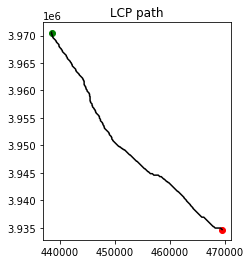

In [15]:
View_LCP_Path(startCoord,stopCoord,Path_UTMx,Path_UTMy,Save_plot_fig)

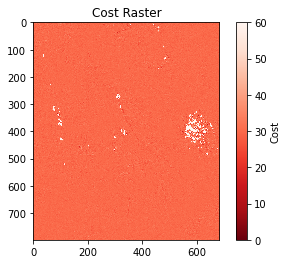

Saving LCP raster fig to output


In [16]:
View_Cost_Raster(Cost_PathFilen,min_color_plot_4_Cost,max_color_plot_4_Cost,Save_plot_fig)

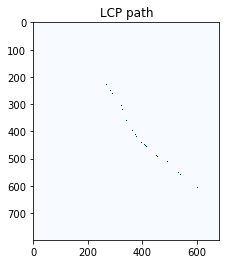

Saving LCP path raster fig to output


In [17]:
View_LCP_Raster(LCP_path_array,Save_plot_fig)


# Write LCP path to output

In [18]:
# Convert UTM to lat, long
Path_ll = ConvCoordMap1ToMap2_Batch(X=Path_UTMx, Y=Path_UTMy, targetEPSG=4326,  sourceEPSG=32611)

Path_Lat = Path_ll[0]
Path_Long = Path_ll[1]

Outmatrix2 = np.append(Path_UTMx,Path_UTMy, axis=1)
Outmatrix3 = np.append(Outmatrix2,Path_Long, axis=1)
Outmatrix4 = np.append(Outmatrix3,Path_Lat, axis=1)

np.savetxt(filename_LCP_Path_out,Outmatrix4,delimiter=' ', fmt="%f")